<a href="https://colab.research.google.com/github/jonnythebard/tf2_workbook/blob/master/VGG_with_augmented_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrianedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.1.0-rc1


In [2]:
# download the data
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip
!unzip -qq -o Food-5K.zip
!mv Food-5K/* .

--2019-12-19 04:37:58--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 2606:4700:30::681f:5030, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  34.0MB/s    in 13s     

2019-12-19 04:38:12 (31.8 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



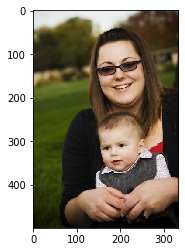

In [3]:
# look at an image for fun
plt.imshow(image.load_img('training/0_807.jpg'))
plt.show()

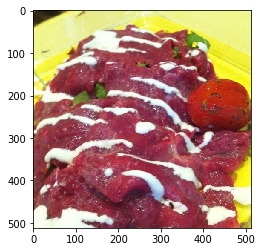

In [4]:
# Food images start with 1, non-food images start with 0
plt.imshow(image.load_img('training/1_610.jpg'))
plt.show()

In [0]:
# split data into directories
!mkdir -p data/train/nonfood
!mkdir -p data/train/food
!mkdir -p data/test/nonfood
!mkdir -p data/test/food

!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [0]:
# data file paths
TRAIN_PATH = "data/train"
TEST_PATH = "data/test"

folders = glob(TRAIN_PATH + "/*")
train_image_files = glob(TRAIN_PATH + "/*/*.jpg")
test_image_files = glob(TEST_PATH + "/*/*.jpg")

# hyper params
IMAGE_SIZE = [200, 200]
BATCH_SIZE = 128

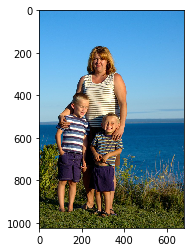

In [7]:
plt.imshow(image.load_img(np.random.choice(train_image_files)))
plt.show()

In [8]:
pre_trained_model = PretrianedModel(input_shape=(IMAGE_SIZE) + [3], weights="imagenet", include_top=False)
pre_trained_model.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [9]:
K = len(folders)
x = Flatten()(pre_trained_model.output)
x = Dense(K, activation="softmax")(x)

model = Model(inputs=pre_trained_model.input, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [10]:
# data augmentation
gen_kwargs = {
    "rotation_range": 20,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "shear_range": 0.1,
    "zoom_range": 0.2,
    "horizontal_flip": True,
    "preprocessing_function": preprocess_input
}
gen = ImageDataGenerator(**gen_kwargs)
gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

train_generator = gen.flow_from_directory(TRAIN_PATH, shuffle=True, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
test_generator = gen_test.flow_from_directory(TEST_PATH, shuffle=True, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
# train the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

fit_kwargs = {
    "generator": train_generator,
    "validation_data": test_generator,
    "epochs": 10,
    "steps_per_epoch": int(np.ceil(len(train_image_files) / BATCH_SIZE)),
    "validation_steps": int(np.ceil(len(test_image_files) / BATCH_SIZE))
}
r = model.fit_generator(**fit_kwargs)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 8 steps
Epoch 1/10
24/24 [==============================] - 48s 2s/step - loss: 2.7967 - accuracy: 0.8973 - val_loss: 1.8583 - val_accuracy: 0.9490
Epoch 2/10
24/24 [==============================] - 44s 2s/step - loss: 0.7927 - accuracy: 0.9643 - val_loss: 0.7710 - val_accuracy: 0.9750
Epoch 3/10
24/24 [==============================] - 44s 2s/step - loss: 0.3731 - accuracy: 0.9803 - val_loss: 0.6243 - val_accuracy: 0.9750
Epoch 4/10
24/24 [==============================] - 44s 2s/step - loss: 0.2339 - accuracy: 0.9890 - val_loss: 0.6489 - val_accuracy: 0.9740
Epoch 5/10
24/24 [==============================] - 44s 2s/step - loss: 0.1401 - accuracy: 0.9900 - val_loss: 0.5863 - val_accuracy: 0.9760
Epoch 6/10
24/24 [==============================] - 44s 2s/step - loss: 0.2000 - accuracy: 0.9883 - val_loss: 0.5682 - val_accuracy: 

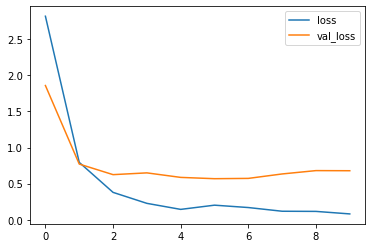

In [12]:
# plot the loss
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

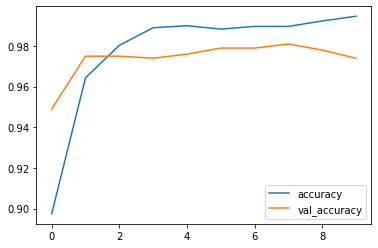

In [13]:
# plot the accuracy
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()